# Verification: reliability diagram 

In [1]:
import os
import sys
import time
import numpy as np
from glob import glob
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator

import h5py

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import verif_utils as vu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

In [5]:
name_output = '/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_2023_ini00_lead{:02d}.hdf'

In [6]:
with h5py.File(save_dir+'ERA5_CDFs.hdf', 'r') as h5io:
    ERA5_CDFs = h5io['ERA5_CDFs'][...]
    indx_in_GFS = h5io['indx_in_GFS'][...]
    indy_in_GFS = h5io['indy_in_GFS'][...]
    
ERA5_CDFs = 3*ERA5_CDFs # mm/hour to mm/3-hour

In [7]:
q_bins = np.arange(0, 1, 0.01)

In [10]:
APCP_90th = ERA5_CDFs[90, ...]

In [14]:
# plt.pcolormesh(APCP_90th, cmap=plt.cm.nipy_spectral_r)
# plt.colorbar()

## Reliability diagram

In [28]:
from sklearn.calibration import calibration_curve

In [19]:
with h5py.File(name_output.format(3)) as h5io:
    MRMS_TRUE = h5io['MRMS_TRUE'][...]

N_time = len(MRMS_TRUE)
N_ens = 10
grid_shape = lon_01.shape # MRMS grid shape

LEADs = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]

In [39]:
PROB_TRUE = np.empty((len(LEADs), N_ens))
PROB_PRED = np.empty((len(LEADs), N_ens))

for l, lead in enumerate(LEADs):
    
    MRMS_TRUE_flag = np.empty((N_time,)+grid_shape)
    MRMS_PRED_prob = np.zeros((N_time,)+grid_shape)
    
    with h5py.File(name_output.format(lead)) as h5io:
        MRMS_TRUE = h5io['MRMS_TRUE'][...]
        MRMS_PRED = h5io['MRMS_PRED'][...]
    
    for ix in range(grid_shape[0]):
        for iy in range(grid_shape[1]):
            
            ix_ERA5 = indx_in_GFS[ix, iy]
            iy_ERA5 = indy_in_GFS[ix, iy]
            
            MRMS_TRUE_flag[:, ix, iy] = MRMS_TRUE[:, ix, iy] >= APCP_90th[ix_ERA5, iy_ERA5]
            for ens in range(N_ens):
                MRMS_PRED_prob[:, ix, iy] += MRMS_PRED[:, ens, ix, iy] >= APCP_90th[ix_ERA5, iy_ERA5]
                
    MRMS_PRED_prob = MRMS_PRED_prob/N_ens
    
    prob_true, prob_pred = calibration_curve(MRMS_TRUE_flag.ravel(), MRMS_PRED_prob.ravel(), n_bins=10)

    PROB_TRUE[l, :] = prob_true
    PROB_PRED[l, :] = prob_pred

In [57]:
prob_true_ = np.array([0.00407913, 0.19077286, 0.25507477, 0.29647477, 0.39351215,
                       0.47627974, 0.58880059, 0.64127242, 0.72004844, 0.95237289])

In [58]:
prob_pred

array([0.00153006, 0.2       , 0.3       , 0.4       , 0.5       ,
       0.6       , 0.7       , 0.8       , 0.9       , 1.        ])

(0.0, 0.99)

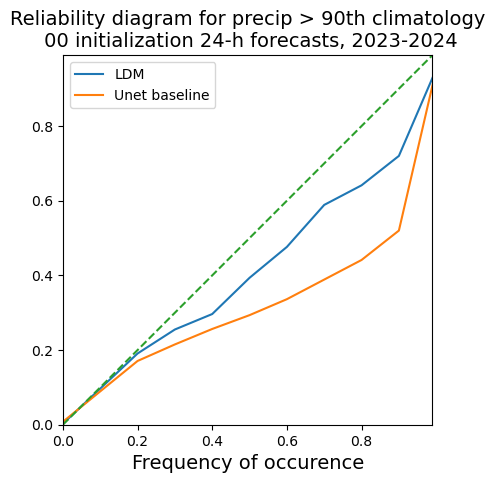

In [71]:
plt.plot(prob_pred, prob_true_, label='LDM')
plt.plot(prob_pred, prob_true, label='Unet baseline')
x_ref = np.linspace(0, 1, 100)
plt.plot(x_ref, x_ref, '--')
plt.legend()
plt.title('Reliability diagram for precip > 90th climatology\n 00 initialization 24-h forecasts, 2023-2024', fontsize=14)
plt.xlabel('Predicted probabilities', fontsize=14)
plt.xlabel('Frequency of occurence', fontsize=14)
plt.axis('scaled')
plt.xlim([0, 0.99])
plt.ylim([0, 0.99])
#plt.plot(PROB_PRED[-1, :], PROB_TRUE[-1, :])

In [ ]:
fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(1, 3, height_ratios=[1,], width_ratios=[2, 0.1, 2])

ax11 = plt.subplot(gs[0, 0])
ax21 = plt.subplot(gs[0, 2])
ax_gap1 = plt.subplot(gs[0, 1])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

ax_gap1.axis("off")


ax11.plot(prob_pred[0, :], prob_true[0, :])

ax11.plot(prob_pred[0, :], prob_true[0, :])